In [1]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/BATH//Dissertaion/Colab
!pip install wandb
!pip install pyDOE
#!pip install stable_baselines3

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

Mounted at /content/drive
/content/drive/My Drive/BATH/Dissertaion/Colab
     |████████████████████████████████| 1.7 MB 7.2 MB/s 
     |████████████████████████████████| 133 kB 63.6 MB/s 
     |████████████████████████████████| 97 kB 5.8 MB/s 
     |████████████████████████████████| 170 kB 55.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=3ff460f23d03c01878a6216dad23829222e879d8c8756e8c84b917aef8ae608f
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=2464f2968ee26b89d3afef616403bca66c0a9dd43ba38ddcfaff2fd9edc1fc57
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=

In [2]:
#import libraries
import gym

import time
import wandb
import numpy as np

import torch 
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 
from dataclasses import dataclass
from typing import Any
from models import Model as Stock_NN

import matplotlib.pyplot as plt
is_ipython = 'inline' in plt.get_backend()
if is_ipython: from IPython import display
if is_ipython: display.clear_output(wait=True)


In [3]:
import random
class Exp_Replay:
    """Experience replay, old samples are removed beyond specified limit
    stores collection of experience tuples (sars), this combats experience correlation"""
    def __init__(self, buffer_n = int(1e5)):   
        
        self.buffer_n = buffer_n
        self.buffer = [None]*buffer_n
        self.idx = 0
        
    def insert(self, sars):
        i = self.idx % self.buffer_n
        self.buffer[i] = sars
        self.idx +=1 # updat index
        
    def sample(self, n_sample):
        if self.idx < self.buffer_n:
            return random.sample(self.buffer[:self.idx], n_sample)
        return random.sample(self.buffer, n_sample)
    
# for data storage
@dataclass
class Sars: # store experience tuples
    state: Any
    action: int
    reward: float
    next_state : Any
    done : bool


In [4]:
class DQN_Agent:
    
    def __init__(self, env,
                 learning_rate = 1e-4, 
                 discount_rate = 0.99,
                 eps_max = 0.9, 
                 eps_min = 0.01,
                 eps_decay = 1e-6, 
                 boltzman_exploration = False,
                 min_rb_size = int(2e4), 
                 sample_size = 100,
                 model_train_freq = 100,
                 tgt_update_freq = 5000,
                 max_epoch = np.inf, 
                 load_model = None,
                 device = 'cudo:0',
                 name = 'Breakout'):
        
        self.lr = learning_rate
        self.gamma = discount_rate
        self.eps_max = eps_max
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        
        self.boltzman = boltzman_exploration 
        self.min_rb = min_rb_size
        self.sample_size = sample_size 
        self.model_train_freq = model_train_freq 
        self.tgt_update_freq = tgt_update_freq
        self.max_epoch = max_epoch 
        self.load_model = load_model
        self.device = device
        self.name = name
        
        self.log = {'loss': [],
                    'avg_reward': [],
                    'eps': [],
                    'step_num': []}
        
        # init env
        self.env = env #gym.make('stocks-v0', frame_bound=(15, 200), window_size=15)
        
        return
    
    def choose_action(self, eps):
        
        if self.boltzman: # use boltzman exploration
                logits = self.m(torch.Tensor(self.last_observation[:,0]).unsqueeze(0).to(self.device))[0]
                action = torch.distributions.Categorical(logits = logits).sample().item()
        else:
            if np.random.random() < eps: # explore action space
                action = self.env.action_space.sample()
            else: # greedy action
                action = self.m(torch.Tensor(self.last_observation[:,0])
                           .unsqueeze(0).to(self.device)).max(-1)[-1].item()
        return action
    
    def run_episode(self, episode):
        '''runs one episode in the taining process.'''
        
        # compute decaying exploration rate as a function of episode
        eps = (self.eps_max - self.eps_min) * np.exp(-self.eps_decay*self.step_count) + self.eps_min
        
        
        self.last_observation = self.env.reset()
        done = False
        
        rolling_reward = 0
        while not done: # until episode ends
            self.tq.update()

            # choose action
            action = self.choose_action(eps)

            # observe state reward by taking action
            obs, reward, done, info = self.env.step(action)
            rolling_reward += reward # sum reward for episode

            
            # insert experienc tuple at top of buffer
            self.rb.insert(Sars(self.last_observation[:,0], action, reward, obs[:,0], done))

            self.last_observation = obs # update observation
            
            #  counters
            self.steps_since_train += 1
            self.step_num += 1
            self.step_count += 1

            # train prediction network
            if self.rb.idx > self.min_rb and self.steps_since_train > self.model_train_freq:

                # train model neural network
                loss = self.train_NN(self.m, 
                                     self.rb.sample(self.sample_size), 
                                     self.tgt,
                                     self.env.action_space.n,
                                     self.device)
                self.steps_since_train = 0 # reset train counter
                
                
                wandb.log({'loss': loss.detach().cpu().item(), 
                           'epsilon': eps, 
                           'avg_reward': self.episode_rewards[-1]}, 
                          step = self.step_num)
                self.save_reward = np.mean(self.episode_rewards[-1])

                self.epochs_since_tgt_update +=1

                # update target nn
                if self.epochs_since_tgt_update > self.tgt_update_freq:
                    self.tgt.load_state_dict(self.m.state_dict())
                    self.epochs_since_tgt_update = 0

                self.epoch += 1
                    
            self.log['avg_reward'].append(rolling_reward)
            self.log['eps'].append(eps)
            self.log['step_num'].append(self.step_num)
            
        return rolling_reward # return episode rewards
    
    def train_NN(self, 
                 model,
                 transition, 
                 tgt, 
                 num_actions, 
                 device):
        '''trains model passed'''
        
        curr_states = torch.stack([torch.Tensor(s.state) for s in transition]).to(device)
        rewards = torch.stack([torch.Tensor([s.reward]) for s in transition]).to(device)
        next_states = torch.stack([torch.Tensor(s.next_state) for s in transition]).to(device)
        actions = [s.action for s in transition]
        if_done = torch.stack([torch.Tensor([0]) if s.done else torch.Tensor([1]) for s in transition]).to(device)
        
        

        with torch.no_grad(): # get best next actions with target network
            next_qvals = tgt(next_states).max(-1)[0] #(N, num_actions)

        model.opt.zero_grad()
        qvals = model(curr_states) # shape: (N, num_actins), get qvals of current state
        H_actions = torch.nn.functional.one_hot(torch.LongTensor(actions), num_actions).to(device)
        
        # MSE loss function
        #loss = ((rewards + if_done[:,0]*next_qvals - torch.sum(qvals * H_actions, -1))**2).mean()

        f_loss = torch.nn.SmoothL1Loss()
        target = torch.sum(qvals * H_actions, -1)
        inputs = rewards.squeeze() + if_done[:,0]*self.gamma*next_qvals # Bellman optimality
        loss = f_loss(target, inputs )
        loss.backward()
        model.opt.step()

        return loss
    
    def train(self):
        '''begin training by running episodes until max or interrupted'''
        
        # init w and b for data viz in dashboard
        wandb.init(project = "DQN_practice", name = self.name)    
        
        # instantiate prediction network
        self.m = Stock_NN(self.env.observation_space.shape,
                           self.env.action_space.n).to(self.device)
        if self.load_model is not None:
            self.m.load_state_dict(torch.load(self.load_model))
        
        # instantiate target network
        self.tgt = Stock_NN(self.env.observation_space.shape, 
                        self.env.action_space.n).to(self.device)
        self.tgt.load_state_dict(self.m.state_dict()) 
        
        # instantiate buffer
        self.rb = Exp_Replay()
        
        # init counterstw
        self.epoch = 0
        self.steps_since_train = 0
        self.epochs_since_tgt_update = 0
        self.step_num = -self.min_rb
        self.step_count = 0
        self.episode_rewards = [np.nan]
        episode = 0
        
        self.tq = tqdm()
        try:
            while episode < self.max_epoch:

                self.episode_rewards.append(self.run_episode(episode))
                episode += 1
                #print(episode)
                clear_output(wait=True)
            r = str(np.random.random())[2:8]
            torch.save(self.tgt.state_dict(), 
                   f"models/Diffusion_{self.step_num}_{r}.pth")
            print('Training Completed.')
        except KeyboardInterrupt: # save model on interrupt
            r = str(np.random.random())[2:8]
            torch.save(self.tgt.state_dict(), 
                   f"models/Diffusion_{self.step_num}_{r}.pth")
            print('Training Interrupted')
        
    
    def test_episode(self, env = None, plot = False, load_model = None):
        
        if env is not None:
            self.env = env
        
        
        if load_model is not None:
            # instantiate prediction network
            self.m = Stock_NN(self.env.observation_space.shape,
                           self.env.action_space.n).to(self.device)
            self.m.load_state_dict(torch.load(load_model))
            
        frames = []
        obs = self.env.reset()
        
        idx = 0
        reward = 0
        done = False
        
        while not done:
            
            action = self.m(torch.Tensor(obs[:,0]).unsqueeze(0).to(self.device)).max(-1)[-1].item()
            obs, r, done, _ = self.env.step(action)
            reward += r
            
            if plot:
                a = self.env.render()
                #plt.figure()
                #plt.imshow(a)
                #plt.show()
                #time.sleep(0.001)
                clear_output(wait=True)
                
        return reward
    

In [5]:
from environment import heat_diffusion

sensor_coords = [[0.1, -0.9],[0.9,0.9],[0.5,0.45]]
env = heat_diffusion(dt = 1e-1, sensor_coords = sensor_coords)

0it [00:00, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
Agent = DQN_Agent(env,
                 learning_rate = 1e-4, 
                 discount_rate = 0.99,
                 eps_max = 0.5, 
                 eps_min = 0.01,
                 eps_decay = 5e-6, 
                 boltzman_exploration = False,
                 min_rb_size = 10000, 
                 sample_size = 500,
                 model_train_freq = 5,
                 tgt_update_freq = 1000,
                 max_epoch = 1000, 
                 load_model = None,#'models/Diffusion_9950_.pth',
                 device = 'cuda:0',
                 name = 'Heat_diffusion_OG')

In [ ]:
Agent.train()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


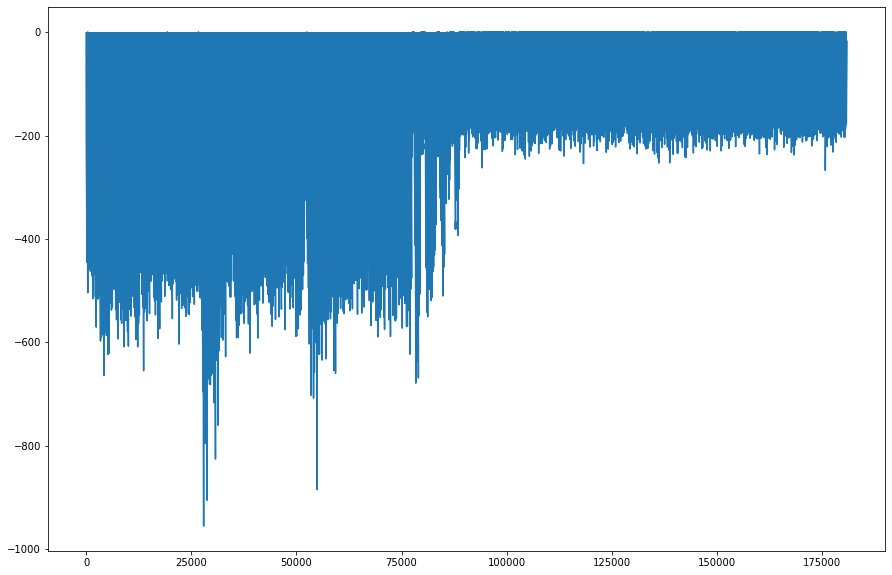

In [ ]:
plt.plot(np.arange(len(Agent.log['avg_reward'])), Agent.log['avg_reward'])

In [ ]:
env.reset()

array([[0.],
       [0.],
       [0.]])

In [ ]:
Agent.test_episode(plot=True, env = env)#, load_model = 'models/Diffusion_9850_324218.pth')#'models/Diffusion_23064_.pth')

-17.267363258100595

(array([-35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.]),
 <a list of 9 Text yticklabel objects>)

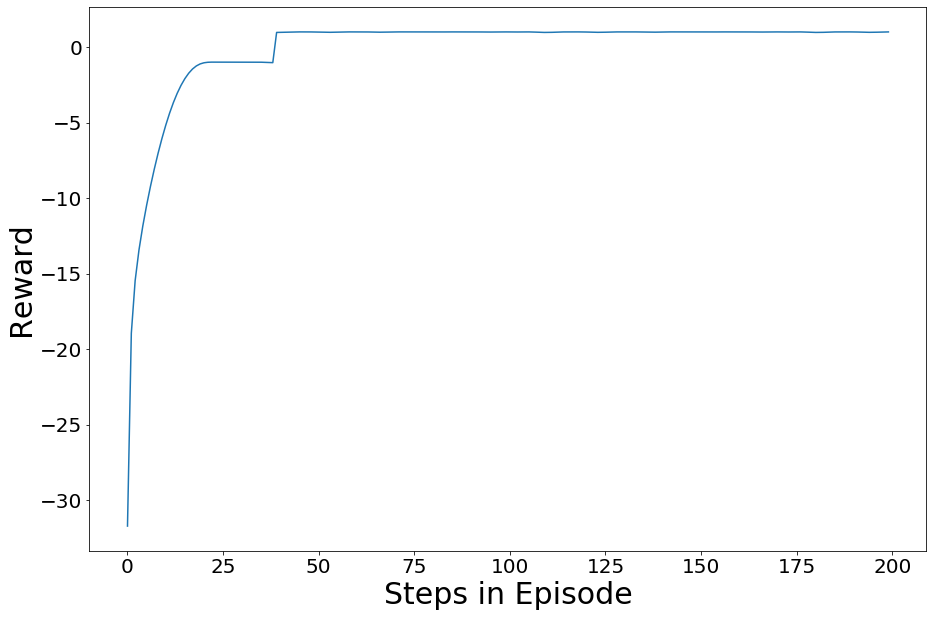

In [ ]:
plt.plot(np.arange(len(env.info['reward'][-200:])), env.info['reward'][-200:])
plt.xlabel('Steps in Episode', size = 30)
plt.ylabel('Reward', size = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig('images/OG_50_epsiodes_3894374.png', dpi = 500)

(-6, 3)

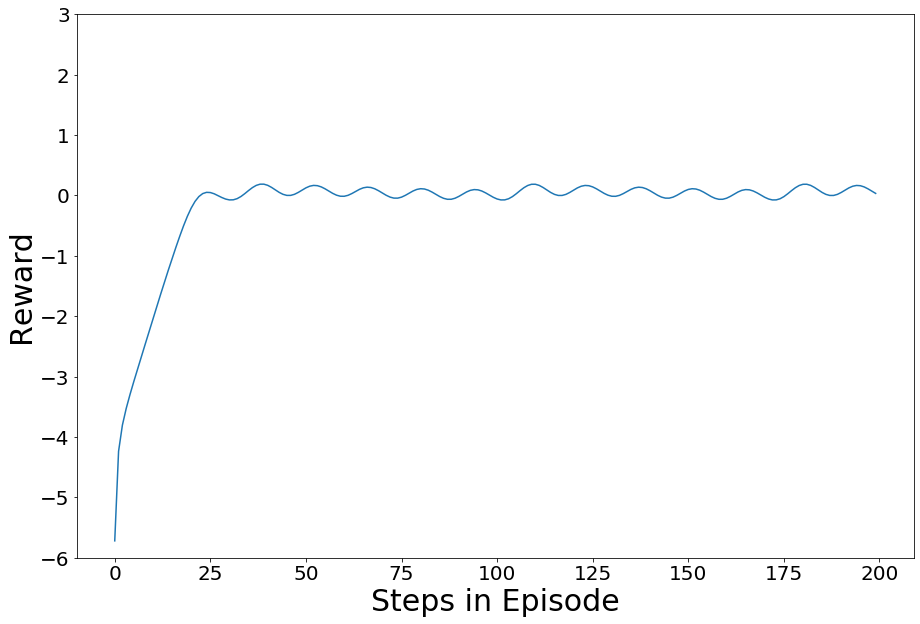

In [ ]:
plt.plot(np.arange(len(env.info['energy'][-200:])), env.info['energy'][-200:])
plt.xlabel('Steps in Episode', size = 30)
plt.ylabel('Reward', size = 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-6,3)
#plt.savefig('images/OG_50_epsiodes_3894374.png', dpi = 500)